# Final Project code

This notebook was instrumental in building code for the comparison.

Note that although 6 models were tested, only 4 will be used for the project

Try:
* Logistic Regression
* SVC
* XGradient boosting
* Ada Boost
* KNN
* Random Forest
* MLP Classifier
* Gradient Boosting Classifier


In [1]:
#---------------------------------- IMPORTANT PACKAGES --------------------------------------------#
print('-------------Importing Useful packages------------')
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
# fairness
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, equalized_odds_ratio, demographic_parity_ratio
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,roc_auc_score, precision_recall_curve, RocCurveDisplay


# Explainability
import shap


-------------Importing Useful packages------------


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [15]:
#----------------------------------- DATA LOADING -------------------------------------------#
print('-----------------Reading CSV file into dataframe-------------------')
data = pd.read_csv('./heart.csv')

data.head()
data.shape
data.info()
#Statistics
data.describe().T

-----------------Reading CSV file into dataframe-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## Preprocessing
This includes:
* Removing outlier leaving 917 observations
* Change age numerical data to ranged categories.
* Numerical data scaling
* Categorical data encoding
* Spliting data

Maybe changing age data to ranged categories.


In [16]:
#----------------------------------- DATA PREPROCESSING -------------------------------------------#
print('-------------------Preprocessing-------------------------')
# Outliers
data= data[data['RestingBP'] > 0]

# Scaling
robust_scale = RobustScaler()
standard_scale = StandardScaler()
minmax_scaler = MinMaxScaler()
# Encoding
ohe= OneHotEncoder()
le = LabelEncoder()

# Categorical Data Encoding
# data['Sex'] = ohe.fit_transform(data['Sex'])
# data['ChestPainType'] = ohe.fit_transform(data['ChestPainType'])
# data['RestingECG'] = ohe.fit_transform(data['RestingECG'])
# data['ExerciseAngina'] = ohe.fit_transform(data['ExerciseAngina'])
# data['ST_Slope'] = ohe.fit_transform(data['ST_Slope'])

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

#data = pd.get_dummies(data, columns=['Sex','ChestPainType','RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=False)

# Change Age to ranged values 
# data['Age']  = data['Age'] .mask(data['Age']  <= 40, 0) # Young
# data['Age']  = data['Age'] .mask(data['Age']  < 60 & data['Age']  > 40, 1) # Middle Aged
# data['Age']  = data['Age'] .mask(data['Age']  > 60, 2) # Seniors

data['Age'] = np.where(data['Age'].between(0,40), 0, data['Age']) # Young
data['Age'] = np.where(data['Age'].between(41,60), 1, data['Age']) # Middle Aged
data['Age'] = np.where(data['Age'].between(61,77), 2, data['Age']) # Seniors

# Scaling Numerical Data
data['Oldpeak'] = robust_scale.fit_transform(data[['Oldpeak']])
# data['Age'] = robust_scale.fit_transform(data[['Age']])
data['RestingBP'] = robust_scale.fit_transform(data[['RestingBP']])
data['Cholesterol'] = robust_scale.fit_transform(data[['Cholesterol']])
data['MaxHR'] = robust_scale.fit_transform(data[['MaxHR']])


-------------------Preprocessing-------------------------


In [18]:
#----------------------------------- SPLIT DATA -------------------------------------------#
print('------------Spliting Data------------')
target= data['HeartDisease']
features= data.drop('HeartDisease', axis=1)
x_dev, x_test, y_dev, y_test = train_test_split(features, target, test_size = 0.20, random_state = 0)

------------Spliting Data------------


## Metrics
Both performance and fairness metrics were eveluated in this.

Might be broken down into 4 subgroups accross sensitive demographic features of young/old and male/female

### Performance
* Precision
* Recall/sensitivity
* F1-score

### Fairness
Based on age and sex sebsitive features:
* Equal odds differennce and ratio.
* Demographic parity difference and ratio.

### Explainability
* Lime for speed
* shap is good for understanding the global importane (https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html)
https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models


Using python's SHAP package to test the understand the model a bit more. Makes it more explainable using Shapley values


In [19]:
#-------------------------------------- PERFORMANCE METRICS ----------------------------------------#
# Metrics Function
def metrics(y_test, y_pred):
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    # Precision, Recall, F1 score
    print(classification_report(y_test,y_pred))
    print(roc_auc_score(y_test,y_pred))

    # ROC
    RocCurveDisplay.from_predictions(y_test,y_pred)
    plt.title('ROC_AUC_Plot')
    plt.show()

#------------------------------------ FAIRNESS EVALUATION ------------------------------------------#
def fairness(x_test, y_test, y_pred):
    age_sensitive= x_test['Age']
    sex_sensitive = x_test['Sex']
    # Demographic Parity
    age_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Demographic Parity Difference is: {age_dpd}')
    print(f'The Age Demographic Parity Ratio is: {age_dpr}')
    print(f'The Sex Demographic Parity Difference is: {sex_dpd}')
    print(f'The Sex Demographic Parity Ratio is: {sex_dpr}')

    # equalized_odds
    age_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Equalized Odds Difference is: {age_eod}')
    print(f'The Age Equalized Odds Ratio is: {age_eor}')
    print(f'The Sex Equalized Odds Difference is: {sex_eod}')
    print(f'The Sex Equalized Odds Ratio is: {sex_eor}')


In [24]:
#-------------------------------------EXPLAINABILITY--------------------------------------#
shap.initjs()
def explain(explainer, X_test):
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

## Build model and test
* Build model fumction

In [32]:

#-------------------------------------- Model ----------------------------------------#
def model(classifier, x_dev, x_test, y_dev, y_test):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")
        pass

    y_pred = classifier.predict(x_test)
    metrics(y_test, y_pred)
    fairness(x_test, y_test, y_pred)
    return classifier, y_pred
    
#--------------------------------------------------------------------------------------------------------#

In [ ]:
# Tree Explainer for random forest, Ada boost, Hist
ex = shap.TreeExplainer(dtree)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Explainer for KNN

# SVC, KNN, Neural use kernel explainers
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)


# Kernel explainer for neural network
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


--------------------------Support Vector Matrix----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       1.00      0.16      0.28        37
           1       0.59      1.00      0.74        45

    accuracy                           0.62        82
   macro avg       0.80      0.58      0.51        82
weighted avg       0.78      0.62      0.53        82

The accuracy for Fold 1 : 0.5810810810810811
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.92      0.32      0.48        37
           1       0.64      0.98      0.77        45

    accuracy                           0.68        82
   macro avg       0.78      0.65      0.63        82
weighted avg       0.77      0.68      0.64        82

The accuracy for Fold 2 : 0.6510510510510511
The fold is : 2 : 
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        37
        

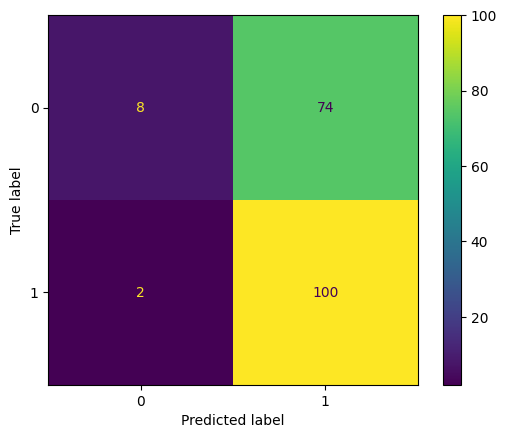

              precision    recall  f1-score   support

           0       0.80      0.10      0.17        82
           1       0.57      0.98      0.72       102

    accuracy                           0.59       184
   macro avg       0.69      0.54      0.45       184
weighted avg       0.68      0.59      0.48       184

0.5389765662362506


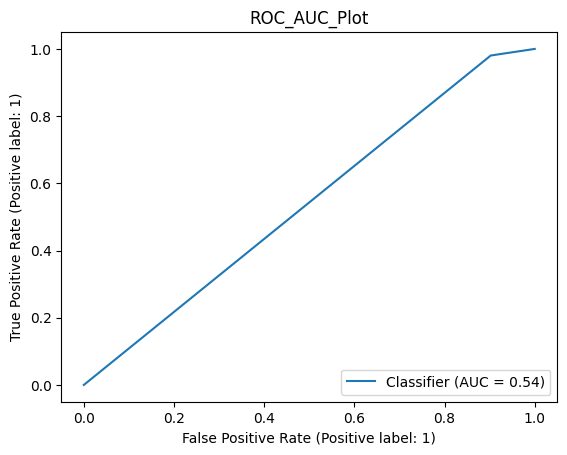

The Age Demographic Parity Difference is: 0.07692307692307687
The Age Demographic Parity Ratio is: 0.9230769230769231
The Sex Demographic Parity Difference is: 0.041568627450980444
The Sex Demographic Parity Ratio is: 0.9563965446318387


Using 733 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


The Age Equalized Odds Difference is: 0.13725490196078427
The Age Equalized Odds Ratio is: 0.8627450980392157
The Sex Equalized Odds Difference is: 0.33333333333333337
The Sex Equalized Odds Ratio is: 0.6666666666666666


  7%|▋         | 12/184 [18:47<4:30:39, 94.41s/it]

In [ ]:
#----------------------------------- SUPPORT VECTOR MATRIX MODEL -------------------------------------------#
print('--------------------------Support Vector Matrix----------------------------------')
classifier, y_pred= model(SVC(random_state=0, gamma = 10, C=10, probability= True), x_dev, x_test, y_dev, y_test)
explain(shap.KernelExplainer(classifier.predict_proba, x_dev), x_test)
#         # #feature importance
# print(classifier.feature_importances)
# feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(13).plot(kind='barh')
# plt.show()

In [ ]:
#------------------------------------  K-NEAREST NEIGHBBOR ------------------------------------------#
print('-----------------------------K Nearest Neighbor-----------------------------')
classifier, y_pred= model(KNeighborsClassifier(n_neighbors=5), x_dev, x_test, y_dev, y_test)

---------------------------Random Forest Vector--------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        37
           1       0.86      0.84      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8411411411411411
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        37
          

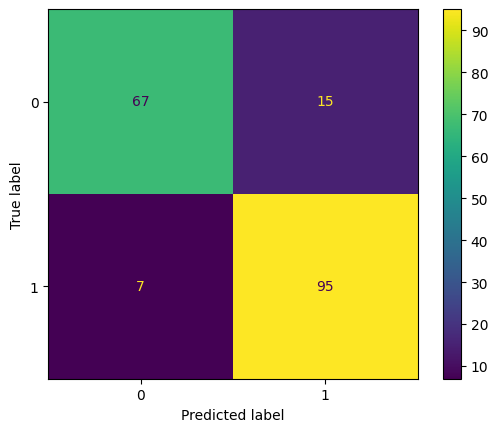

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184

0.8742228598756576


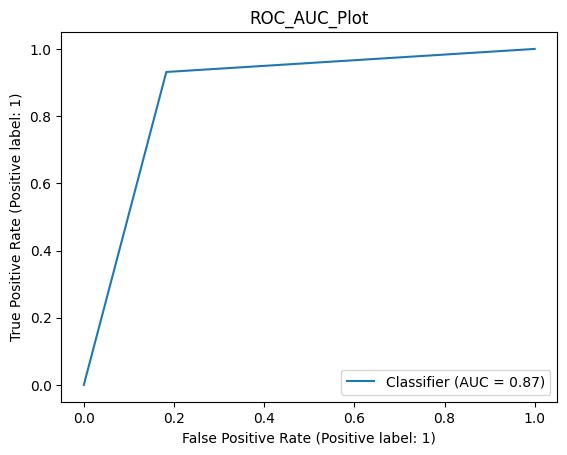

The Age Demographic Parity Difference is: 0.6573498964803313
The Age Demographic Parity Ratio is: 0.22466422466422464
The Sex Demographic Parity Difference is: 0.4807843137254902
The Sex Demographic Parity Ratio is: 0.2998286693318104
The Age Equalized Odds Difference is: 0.5
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.28125
The Sex Equalized Odds Ratio is: 0.48214285714285715


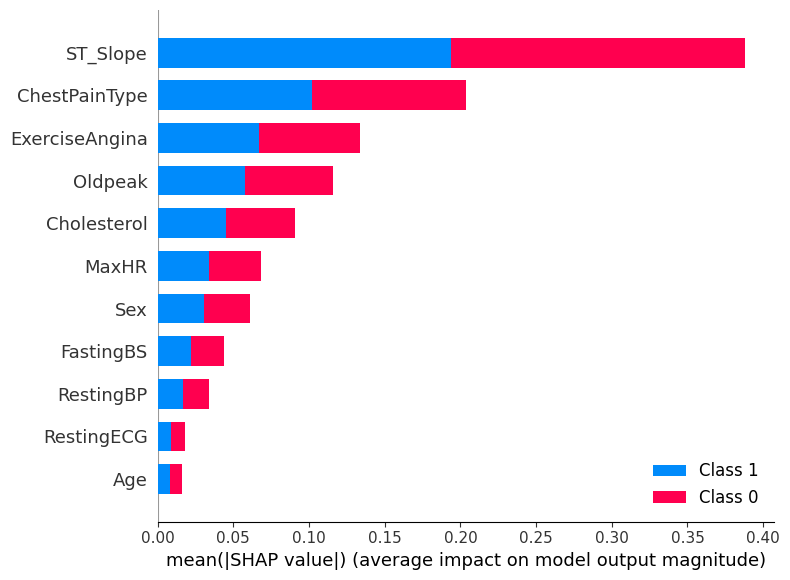

In [ ]:
#-------------------------------------- RANDOM FOREST CLASSIFIER ----------------------------------------#
print('---------------------------Random Forest Vector--------------------------------')
classifier, y_pred= model(RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=5, max_depth=10), x_dev, x_test, y_dev, y_test)
explain(shap.TreeExplainer(classifier), x_test)

---------------------------------------Ada Boost-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        37
           1       0.87      0.76      0.81        45

    accuracy                           0.80        82
   macro avg       0.81      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82

The accuracy for Fold 1 : 0.8102102102102102
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.80      0.82      0.81        45

    accuracy                           0.79        82
   macro avg       0.79      0.79      0.79        82
weighted avg       0.79      0.79      0.79        82

The accuracy for Fold 2 : 0.7894894894894895
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        37
           1      

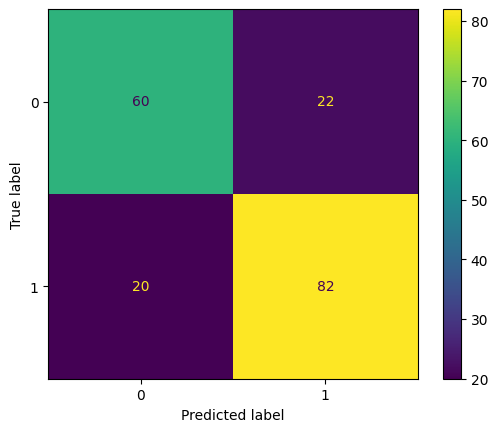

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        82
           1       0.79      0.80      0.80       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184

0.7678144428503109


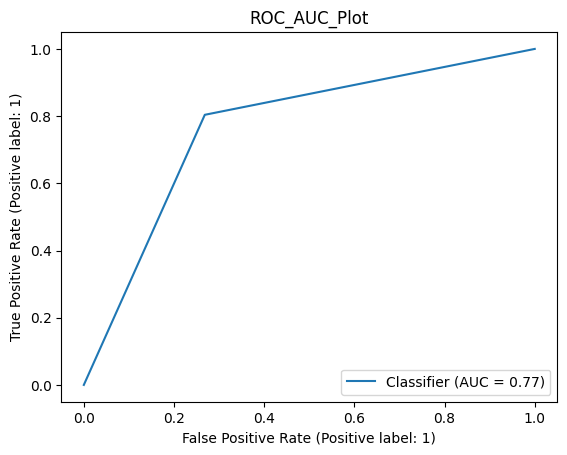

The Age Demographic Parity Difference is: 0.4834368530020704
The Age Demographic Parity Ratio is: 0.282642089093702
The Sex Demographic Parity Difference is: 0.1521568627450981
The Sex Demographic Parity Ratio is: 0.7435558493060145
The Age Equalized Odds Difference is: 0.29831932773109243
The Age Equalized Odds Ratio is: 0.16470588235294117
The Sex Equalized Odds Difference is: 0.20833333333333337
The Sex Equalized Odds Ratio is: 0.7489711934156378


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

In [44]:
#-------------------------------------- ADABOOST ----------------------------------------#
# hyperparameter tuning
print('---------------------------------------Ada Boost-----------------------')
classifier, y_pred= model(AdaBoostClassifier(random_state=0, n_estimators=100, learning_rate=0.001), x_dev, x_test, y_dev, y_test )
explain(shap.TreeExplainer(classifier), x_test)

---------------------------------------GradientBoostingClassifier-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.97      0.82      0.89        45

    accuracy                           0.89        82
   macro avg       0.90      0.90      0.89        82
weighted avg       0.90      0.89      0.89        82

The accuracy for Fold 1 : 0.8975975975975976
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.88      0.84      0.86        45

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 2 : 0.8546546546546548
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        37
 

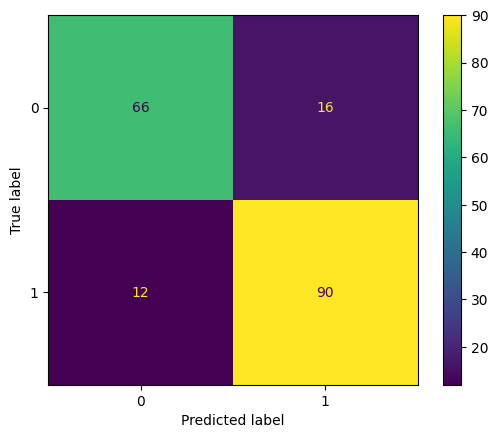

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184

0.8436154949784792


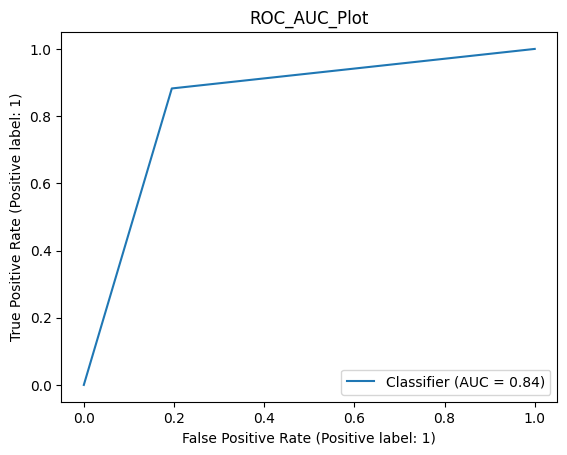

The Age Demographic Parity Difference is: 0.6614906832298137
The Age Demographic Parity Ratio is: 0.17760617760617758
The Sex Demographic Parity Difference is: 0.4901960784313725
The Sex Demographic Parity Ratio is: 0.26470588235294124
The Age Equalized Odds Difference is: 0.5
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.40625
The Sex Equalized Odds Ratio is: 0.44505494505494503


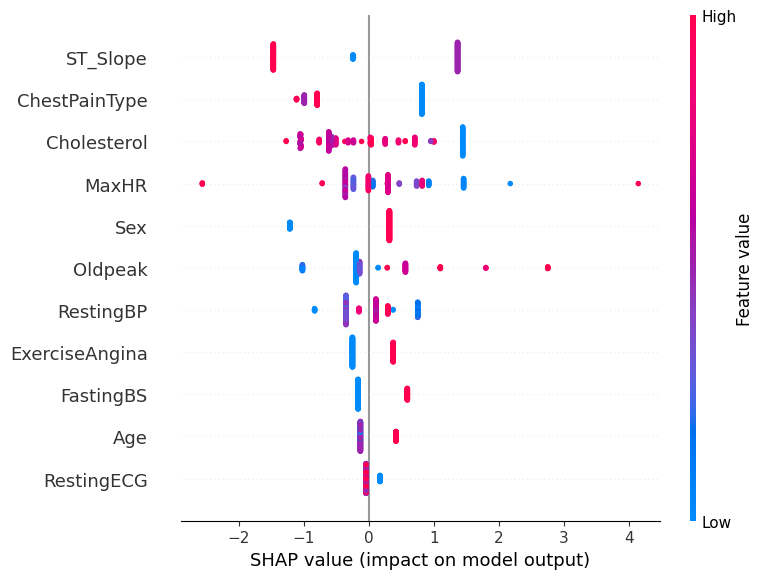

In [45]:
#-------------------------------------- GRADIENT BOOSTING CLASSIFIER ----------------------------------------#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
print('---------------------------------------GradientBoostingClassifier-----------------------')
classifier, y_pred= model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), x_dev, x_test, y_dev, y_test )
explain(shap.TreeExplainer(classifier), x_test)

---------------------------------------MLP Classifier----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.76      0.84      0.79        37
           1       0.85      0.78      0.81        45

    accuracy                           0.80        82
   macro avg       0.80      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82

The accuracy for Fold 1 : 0.8078078078078078


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        37
           1       0.78      0.80      0.79        45

    accuracy                           0.77        82
   macro avg       0.77      0.76      0.77        82
weighted avg       0.77      0.77      0.77        82

The accuracy for Fold 2 : 0.7648648648648648
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        37
           1       0.87      0.89      0.88        45

    accuracy                           0.87        82
   macro avg       0.87      0.86      0.86        82
weighted avg       0.87      0.87      0.87        82

The accuracy for Fold 3 : 0.8633633633633634


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


The fold is : 3 : 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        37
           1       0.84      0.80      0.82        45

    accuracy                           0.80        82
   macro avg       0.80      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82

The accuracy for Fold 4 : 0.8054054054054054
The fold is : 4 : 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.85      0.89      0.87        45

    accuracy                           0.85        81
   macro avg       0.85      0.85      0.85        81
weighted avg       0.85      0.85      0.85        81

The accuracy for Fold 5 : 0.8472222222222223


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


The fold is : 5 : 
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.91      0.93      0.92        45

    accuracy                           0.91        81
   macro avg       0.91      0.91      0.91        81
weighted avg       0.91      0.91      0.91        81

The accuracy for Fold 6 : 0.911111111111111
The fold is : 6 : 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        36
           1       0.87      0.87      0.87        45

    accuracy                           0.85        81
   macro avg       0.85      0.85      0.85        81
weighted avg       0.85      0.85      0.85        81

The accuracy for Fold 7 : 0.85


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


The fold is : 7 : 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        36
           1       0.88      0.93      0.90        45

    accuracy                           0.89        81
   macro avg       0.89      0.88      0.89        81
weighted avg       0.89      0.89      0.89        81

The accuracy for Fold 8 : 0.8833333333333333
The fold is : 8 : 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.85      0.89      0.87        45

    accuracy                           0.85        81
   macro avg       0.85      0.85      0.85        81
weighted avg       0.85      0.85      0.85        81

The accuracy for Fold 9 : 0.8472222222222223


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


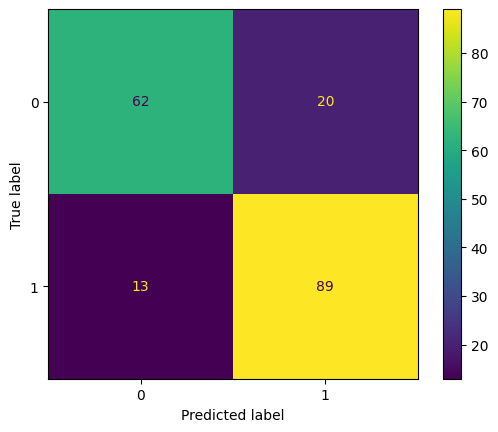

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.82      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184

0.8143232902917265


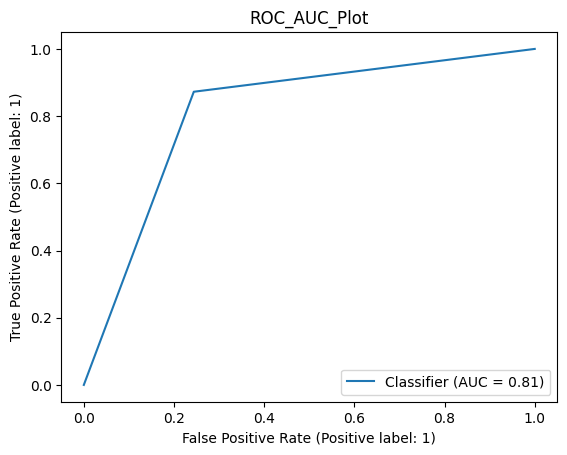

The Age Demographic Parity Difference is: 0.6138716356107661
The Age Demographic Parity Ratio is: 0.2368082368082368
The Sex Demographic Parity Difference is: 0.5101960784313725
The Sex Demographic Parity Ratio is: 0.25699600228440894
The Age Equalized Odds Difference is: 0.36974789915966383
The Age Equalized Odds Ratio is: 0.13725490196078433
The Sex Equalized Odds Difference is: 0.39583333333333337
The Sex Equalized Odds Ratio is: 0.34033613445378147
Provided model function fails when applied to the provided data set.


TypeError: 'numpy.ndarray' object is not callable

In [46]:
#-------------------------------------- MULTI-lAYER PERCEPRTION ----------------------------------------#
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
print('---------------------------------------MLP Classifier----------------------')
classifier, y_pred= model(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), x_dev, x_test, y_dev, y_test )
explain(shap.KernelExplainer(y_pred, x_dev), x_test)

## References
General resources used during development of the model.
Kaggle notebooks:
* Heart Disease Prediction using 9 models: https://kaggle.com/code/fahadrehman07/heart-disease-prediction-using-9-models
* https://kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models
* https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
* https://www.kaggle.com/code/durgancegaur/data-imbalance-eda-87-auc?scriptVersionId=88319036
SHAP values
*******